<a href="https://colab.research.google.com/github/eddiechn/oct-disease/blob/main/OCT_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf


# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
main_path = "data/OCT"

# val, test, train have already been split in the kaggle database

train_dir = f"{main_path}/train"
val_dir = f"{main_path}/val"
test_dir = f"{main_path}/test"


In [13]:
# paths
print(train_dir)
print(val_dir)
print(test_dir)

data/OCT/train
data/OCT/val
data/OCT/test


In [15]:
# diseases
diseases = os.listdir(train_dir)
diseases.remove('.DS_Store')
diseases


['CNV', 'DME', 'DRUSEN', 'NORMAL']

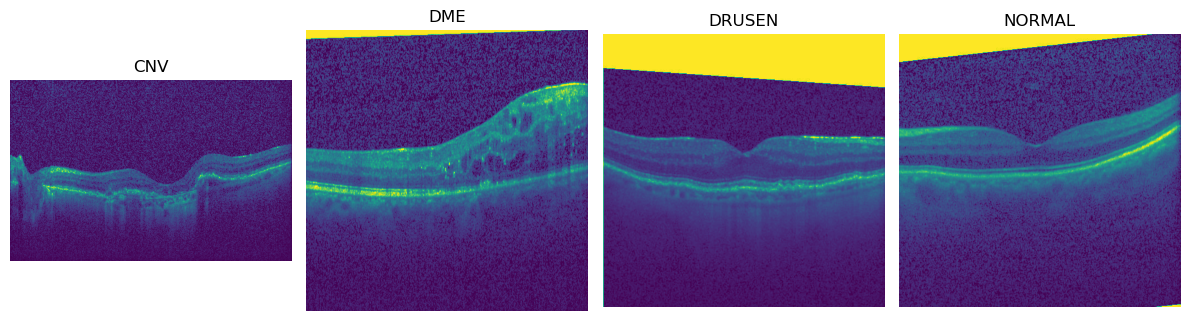

In [16]:


# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Ensure we don't try to plot more images than available axes
for i, ax in enumerate(axs):
    if i < len(diseases):
        disease = diseases[i]
        disease_dir = os.path.join(train_dir, disease)

        # List all images in the disease directory
        images = os.listdir(disease_dir)

        # Select a random image
        img_path = os.path.join(disease_dir, np.random.choice(images))

        # Load and display the image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

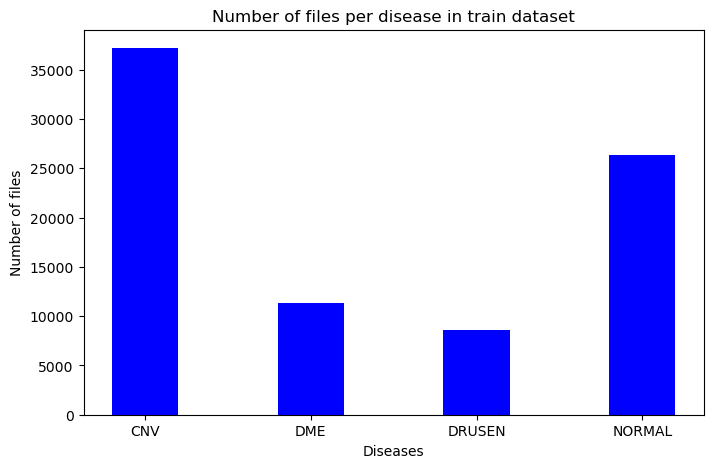

In [17]:
dataset = train_dir
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

for disease in image_counts.keys():
    disease_dir = os.path.join(dataset, disease)
    image_counts[disease] = len(os.listdir(disease_dir))

diseases = list(image_counts.keys())
count = list(image_counts.values())

fig = plt.figure(figsize=(8,5))

plt.bar(diseases, count, color="blue", width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Number of files")
plt.title("Number of files per disease in train dataset")
plt.show()

# Training model using InceptionV3 pretrained model

In [18]:
batch_size = 32

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda

In [20]:
image_gen = ImageDataGenerator(rescale=1/255,
                              shear_range=0.15,
                              zoom_range=0.2,
                              horizontal_flip=True,
                               rotation_range=25,
                              )

In [21]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True,
                                                class_mode="categorical"
                                               )

Found 83484 images belonging to 4 classes.


In [22]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True,
                                               class_mode="categorical"
                                               )

Found 968 images belonging to 4 classes.


In [24]:
def create_model() :

  input_shape = (299, 299, 1)

  inputs = Input(shape=input_shape)

  # three channels
  x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

  inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

  x = Flatten()(inception_model.output)

  # Fully connected layers
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(64, activation='relu')(x)


  # output
  outputs = Dense(4, activation='softmax')(x)

  final_model = tf.keras.Model(inputs=inputs, outputs=outputs)

  final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return final_model

final_model = create_model_tpu()

final_model.summary()


2024-08-05 23:27:31.151270: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-05 23:27:31.151294: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-05 23:27:31.151303: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-05 23:27:31.151725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-05 23:27:31.152057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 29s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 1)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 299, 299, 3)          0         ['input_1[0][0]',             
                                                                     'input_1[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['concatenate[0][0]']         
                            

In [25]:

# Define log directory
logdir = 'logs'

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=4,
    restore_best_weights=True
)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='InceptionV3_tuning.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)


In [26]:
model_results = final_model.fit(train_image_gen,epochs=10,
                    validation_data=test_image_gen,
                    callbacks=[tensorboard_callback, early_stopping, checkpoint])

Epoch 1/10


2024-08-05 23:29:41.903244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2609/2609 [==============================] - ETA: 0s - loss: 1.1073 - accuracy: 0.6147

2024-08-06 01:00:41.532978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.81579, saving model to InceptionV3_tuning.keras


ValueError: The following argument(s) are not supported with the native Keras format: ['options']

#### 